# Introduction

**US COVID-19 Vaccine Administration**

On May 4, 2021, United States President Biden announced a goal to administer at least one coronavirus vaccine shot to 70% of the U.S. adult population by July 4th. Read the official statement [here.](https://www.whitehouse.gov/briefing-room/statements-releases/2021/05/04/fact-sheet-president-biden-to-announce-goal-to-administer-at-least-one-vaccine-shot-to-70-of-the-u-s-adult-population-by-july-4th/)

Per the briefing, the White House's vaccine campaign actions to reach this goal include:
- **Making access to vaccinations more convenient** by increasing walk-in vaccinations at local pharmacies across the nation and moving to smaller, community-based and mobile vaccination clinics
- **Supporting community vaccine education and local outreach efforts** by expanding the workforce of community-based organizations, supporting underserved communities with the tools needed to get vaccinated, and supporting the next phase of state and local vaccine outreach efforts
- **Providing easier access to those living in rural communities and bolster efforts to reach rural Americans in the response** by shipping new allocations of vaccine to rural health clinicas, increasing vaccine education and outreach efforts in rural communities, and increasing funding for rural health clinics and hospitals to respond to COVID-19 with testing and mitigation measures
- **Launch a comprehensive plan to vaccinate the nation’s adolescents, should the FDA authorize a vaccine for younger ages**

Here we will perform a time series analysis on the CDC's public vaccine distribution and administration dataset as of June 13, 2021 to predict whether or not the US will meet the target, then provide the Biden Administration a set of recommended actions to take in the final 3 weeks in order to reach the goal.

In [96]:
# style notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

In [2]:
#import standard packages
import pandas as pd
pd.set_option('display.max_columns', 0)
import numpy as np

#import viz packages
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,5) #setting figures to timeseries-friendly
import plotly.express as px
import plotly.graph_objects as go

#import time series tools from statsmodels
import statsmodels.tsa.api as tsa
import statsmodels
print(f'Statsmodels version = {statsmodels.__version__}')

#import custom functions from .py file
import functions as func

Statsmodels version = 0.12.0


# Data Source

Data for this analysis was sourced from the CDC's [official COVID-19 Vaccination dataset](https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-Jurisdi/unsk-b7fc), on June 13, 2021.

Description of the data source:

> Overall US COVID-19 Vaccine deliveries and administration data at national and jurisdiction level. Data represents all vaccine partners including jurisdictional partner clinics, retail pharmacies, long-term care facilities, dialysis centers, Federal Emergency Management Agency and Health Resources and Services Administration partner sites, and federal entity facilities. 

## Notes on source data

- "Adults" defined as age 18+
- To estimate the 12+, 18+ and 65+ populations for US territories, CDC assumes that the proportions of people aged 12 years and older, 18 years and older and people aged 65 years and older in the territories are the same as in the aggregate of the 50 states, DC, and Puerto Rico (85%, 78% and 17%, respectively).
- Vaccination data on CDC’s COVID Data Tracker are typically at least 48 hours behind a state’s vaccination data reports.
- This analysis focuses on the 50 states, District of Columbia, and Puerto Rico

In [3]:
#load the full dataset
full_dataset = pd.read_csv('./data/COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv')
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11798 entries, 0 to 11797
Data columns (total 69 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Date                                    11798 non-null  object 
 1   MMWR_week                               11798 non-null  int64  
 2   Location                                11798 non-null  object 
 3   Distributed                             11798 non-null  int64  
 4   Distributed_Janssen                     11798 non-null  int64  
 5   Distributed_Moderna                     11798 non-null  int64  
 6   Distributed_Pfizer                      11798 non-null  int64  
 7   Distributed_Unk_Manuf                   11798 non-null  int64  
 8   Dist_Per_100K                           11798 non-null  int64  
 9   Distributed_Per_100k_12Plus             11798 non-null  int64  
 10  Distributed_Per_100k_18Plus             11798 non-null  in

There are no null values in the dataset.

# EDA & Preprocessing

Next step is to explore the data, understand trends within, engineer a "region" feature, and slice the data into subsets for analysis.

Steps:

1. Select feature to analyze
1. Convert date feature to datetime data type
1. Process out some locations 
1. Feature engineering
1. Create dataframes for 3 analyses: National, by State, by Region
1. Visualize the trend in vaccine administration as of 6/13/2021 for each of the 3 subsets
    
    
_________
**Select Feature To Analyze**


In [4]:
#review columns, referencing column definitions: 
    #https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-Jurisdi/unsk-b7fc
full_dataset.columns

Index(['Date', 'MMWR_week', 'Location', 'Distributed', 'Distributed_Janssen',
       'Distributed_Moderna', 'Distributed_Pfizer', 'Distributed_Unk_Manuf',
       'Dist_Per_100K', 'Distributed_Per_100k_12Plus',
       'Distributed_Per_100k_18Plus', 'Distributed_Per_100k_65Plus',
       'Administered', 'Administered_12Plus', 'Administered_18Plus',
       'Administered_65Plus', 'Administered_Janssen', 'Administered_Moderna',
       'Administered_Pfizer', 'Administered_Unk_Manuf', 'Administered_Fed_LTC',
       'Administered_Fed_LTC_Residents', 'Administered_Fed_LTC_Staff',
       'Administered_Fed_LTC_Unk', 'Administered_Fed_LTC_Dose1',
       'Administered_Fed_LTC_Dose1_Residents',
       'Administered_Fed_LTC_Dose1_Staff', 'Administered_Fed_LTC_Dose1_Unk',
       'Admin_Per_100K', 'Admin_Per_100k_12Plus', 'Admin_Per_100k_18Plus',
       'Admin_Per_100k_65Plus', 'Recip_Administered',
       'Administered_Dose1_Recip', 'Administered_Dose1_Pop_Pct',
       'Administered_Dose1_Recip_12Plus'

Of the features available, the one that matches most closely to the goal is **Administered_Dose1_Recip_18PlusPop_Pct,** which represents the percent of adult (18+) population with at lease one dose based on the jurisdiction where recipient lives.

In [5]:
#create a dataframe with only the target feature, date, and location
ts1 = full_dataset[['Date', 'Location', 'Administered_Dose1_Recip_18PlusPop_Pct']]
ts1.head()

Date Location  Administered_Dose1_Recip_18PlusPop_Pct
0  06/13/2021       ND                                    54.6
1  06/13/2021       DE                                    68.1
2  06/13/2021       GA                                    52.2
3  06/13/2021       WA                                    71.5
4  06/13/2021       NM                                    72.6

_______

**Convert Date Feature to `datetime` Data Type**


In [6]:
# convert Date column to datetime data type
ts1['Date'] = pd.to_datetime(ts1['Date'])

<ipython-input-6-a2d07396e975>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts1['Date'] = pd.to_datetime(ts1['Date'])


In [7]:
ts1.set_index('Date', inplace=True)

In [8]:
ts1

Location  Administered_Dose1_Recip_18PlusPop_Pct
Date                                                       
2021-06-13       ND                                    54.6
2021-06-13       DE                                    68.1
2021-06-13       GA                                    52.2
2021-06-13       WA                                    71.5
2021-06-13       NM                                    72.6
...             ...                                     ...
2020-12-13       US                                     0.0
2020-12-13       GU                                     0.0
2020-12-13       AS                                     0.0
2020-12-13       VI                                     0.0
2020-12-13      LTC                                     0.0

[11798 rows x 2 columns]

_____

**Process Out Some Locations**

This analysis will focus on the 50 US states, DC, and Puerto Rico. Other jurisdictions included in the original dataset are US-owned teritories and federal entities.

In [9]:
#explore jurisdictions represented in the dataset
locs = sorted(list(ts1.Location.unique()))
print(len(locs)) #goal: 52
print(locs)

65
['AK', 'AL', 'AR', 'AS', 'AZ', 'BP2', 'CA', 'CO', 'CT', 'DC', 'DD2', 'DE', 'FL', 'FM', 'GA', 'GU', 'HI', 'IA', 'ID', 'IH2', 'IL', 'IN', 'KS', 'KY', 'LA', 'LTC', 'MA', 'MD', 'ME', 'MH', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'RP', 'SC', 'SD', 'TN', 'TX', 'US', 'UT', 'VA', 'VA2', 'VI', 'VT', 'WA', 'WI', 'WV', 'WY']


In [10]:
#remove US territories
locs.remove('AS') #remove American Samoa
locs.remove('FM') #remove Federated States of Micronesia
locs.remove('GU') #remove Guam
locs.remove('MH') #remove Marshall Islands
locs.remove('MP') #remove Northern Mariana Islands
locs.remove('RP') #remove Palau
locs.remove('VI') #remove US Virgin Islands
#remove federal entities
locs.remove('BP2') #bureau of prisons
locs.remove('DD2') #dept of defense
locs.remove('IH2') #indian health services
locs.remove('LTC') #long term care
locs.remove('VA2') #veterans health
#remove US total to use this as a list of the sub-jurisdictions
locs.remove('US') 

In [11]:
print(len(locs))
print(locs)

52
['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']


______

**Create Dataframes & Visualizations To Analyze National Trends, Trends By State, & Trends By Region**

## National Vaccine Administration

In [12]:
# parse out the national data for modeling & analysis
ts1_national = ts1[ts1['Location'] == 'US']
ts1_national.drop(columns='Location', inplace=True)
# set frequency to days
ts1_national=ts1_national.resample('D').asfreq()
ts1_national

/Users/kristincooper/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Administered_Dose1_Recip_18PlusPop_Pct
Date                                              
2020-12-13                                     0.0
2020-12-14                                     0.0
2020-12-15                                     0.0
2020-12-16                                     0.0
2020-12-17                                     0.0
...                                            ...
2021-06-09                                    63.9
2021-06-10                                    64.0
2021-06-11                                    64.1
2021-06-12                                    64.3
2021-06-13                                    64.4

[183 rows x 1 columns]

In [13]:
#start analysis when reported #'s exceed 0 so as to not confuse the model
ts1_national = ts1_national[ts1_national['Administered_Dose1_Recip_18PlusPop_Pct']>0]

In [14]:
# plot national trend
func.plot_vax(ts=ts1_national, 
         title="National Trend in Vaccine Administration (% of US pop rec'd 1 or more doses)",
         labels={'value': '% of US Pop', 'variable': 'Legend'})

As of June 13th, 64.4% of the US adult population have received at least one dose of a COVID-19 vaccine.

## Vaccine Administration by State

In [15]:
# create a separate dataframe with only the 50 states + DC + PR
ts1_states = ts1[ts1['Location'] == locs[0]]
for x in locs[1:]:
    ts1_states = pd.concat([ts1_states, ts1[ts1['Location'] == x]], axis=0)
ts1_states

Location  Administered_Dose1_Recip_18PlusPop_Pct
Date                                                       
2021-06-13       AK                                    59.5
2021-06-12       AK                                    59.4
2021-06-11       AK                                    59.3
2021-06-10       AK                                    59.2
2021-06-09       AK                                    59.1
...             ...                                     ...
2020-12-18       WY                                     0.0
2020-12-17       WY                                     0.0
2020-12-16       WY                                     0.0
2020-12-15       WY                                     0.0
2020-12-14       WY                                     0.0

[9464 rows x 2 columns]

In [16]:
# set frequency to days
ts1_states = ts1_states.groupby('Location').resample('D').asfreq()
ts1_states

Location  Administered_Dose1_Recip_18PlusPop_Pct
Location Date                                                       
AK       2020-12-14       AK                                     0.0
         2020-12-15       AK                                     0.0
         2020-12-16       AK                                     0.0
         2020-12-17       AK                                     0.0
         2020-12-18       AK                                     0.0
...                      ...                                     ...
WY       2021-06-09       WY                                    47.9
         2021-06-10       WY                                    47.9
         2021-06-11       WY                                    47.9
         2021-06-12       WY                                    48.1
         2021-06-13       WY                                    48.2

[9464 rows x 2 columns]

In [17]:
ts1_states = ts1_states.drop(columns='Location').reset_index().set_index('Date')

In [18]:
# start when doses administered > 0
ts1_states = ts1_states[ts1_states['Administered_Dose1_Recip_18PlusPop_Pct']>0]

In [19]:
# visualize states
func.plot_vax(ts1_states, color='Location', 
              title="Trend in Vaccine Administration by State (% of state pop rec'd 1 or more doses)", 
              labels={'value': '% of State Pop'})

States range between 83.5% (Vermont) and 44.8% (Mississippi) adult vaccine administration as of June 13th.

## Vaccine Administration by Region

In [20]:
#create region lists
northeast = ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA']
midwest = ['IN', 'IL', 'MI', 'OH', 'WI', 'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD']
south = ['DE', 'DC', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'WV', 'AL', 'KY', 'MS', 'TN', 
         'AR', 'LA', 'OK', 'TX', 'PR']
west = ['AZ', 'CO', 'ID', 'NM', 'MT', 'UT', 'NV', 'WY', 'AK', 'CA', 'HI', 'OR', 'WA']

#check that all 52 locations are captured in a list
len(northeast+midwest+south+west)

52

In [21]:
#define function to determine region given state, to use in a lambda function and apply to the whole dataframe
def region(state):
    region = str()
    if state in northeast:
        region = 'Northeast'
    if state in midwest:
        region = 'Midwest'
    if state in south:
        region = 'South'
    if state in west:
        region = 'West'
    return region

In [22]:
#check the function works as intended
region(ts1_states.Location[0])

'West'

In [23]:
#map function to all rows in the states df
ts1_region = ts1_states.copy()
ts1_region['Region'] = ts1_region.Location.map(lambda x: region(x))

In [24]:
#check that the map function worked
ts1_region.Region.value_counts()

South        2166
West         1573
Midwest      1452
Northeast    1089
Name: Region, dtype: int64

In [25]:
ts1_region = ts1_region.drop(columns='Location')
ts1_region

Administered_Dose1_Recip_18PlusPop_Pct Region
Date                                                     
2021-02-13                                    20.6   West
2021-02-14                                    21.3   West
2021-02-15                                    21.6   West
2021-02-16                                    21.8   West
2021-02-17                                    22.0   West
...                                            ...    ...
2021-06-09                                    47.9   West
2021-06-10                                    47.9   West
2021-06-11                                    47.9   West
2021-06-12                                    48.1   West
2021-06-13                                    48.2   West

[6280 rows x 2 columns]

In [26]:
# group by date, then region to get trends per region
ts1_region = ts1_region.reset_index().groupby(['Date', 'Region']).mean().reset_index().set_index('Date')

In [27]:
# visualize regional trends
func.plot_vax(ts1_region, color='Region',
              title="Trend in Vaccine Administration by Region (% of region pop rec'd 1 or more doses)",
              labels={'value': '% of Region Pop'})

The northeast leads the nation, having vaccinated 75.8% of their adult population. The other 3 regions range between 57-63% administrtion rate amongst adults.

# National Analysis

In [28]:
ts1_national

Administered_Dose1_Recip_18PlusPop_Pct
Date                                              
2021-02-13                                    11.9
2021-02-14                                    12.4
2021-02-15                                    12.7
2021-02-16                                    12.9
2021-02-17                                    13.1
...                                            ...
2021-06-09                                    63.9
2021-06-10                                    64.0
2021-06-11                                    64.1
2021-06-12                                    64.3
2021-06-13                                    64.4

[121 rows x 1 columns]

In [29]:
#visualize rolling mean, calculate stationarity
func.stationarity_check(ts1_national)

Test Stat   p-value  k-lags  n-observations  Stationary?
AD Fuller Test  -1.493298  0.536824       7             113        False

Test Stat   p-value  k-lags  n-observations  Stationary?
AD Fuller Test  -1.493298  0.536824       7             113        False

In [30]:
func.stationarity_check(ts1_national.diff().dropna())

Test Stat  p-value  k-lags  n-observations  Stationary?
AD Fuller Test  -0.961288  0.76712       6             113        False

Test Stat  p-value  k-lags  n-observations  Stationary?
AD Fuller Test  -0.961288  0.76712       6             113        False

In [31]:
func.stationarity_check(ts1_national.diff(periods=7).dropna())

Test Stat   p-value  k-lags  n-observations  Stationary?
AD Fuller Test  -0.097104  0.949726       7             106        False

Test Stat   p-value  k-lags  n-observations  Stationary?
AD Fuller Test  -0.097104  0.949726       7             106        False

In [32]:
#decompose timeseries
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(ts1_national))
trend = decomposition.trend.dropna()
seasonal = decomposition.seasonal.dropna()
residual = decomposition.resid.dropna()

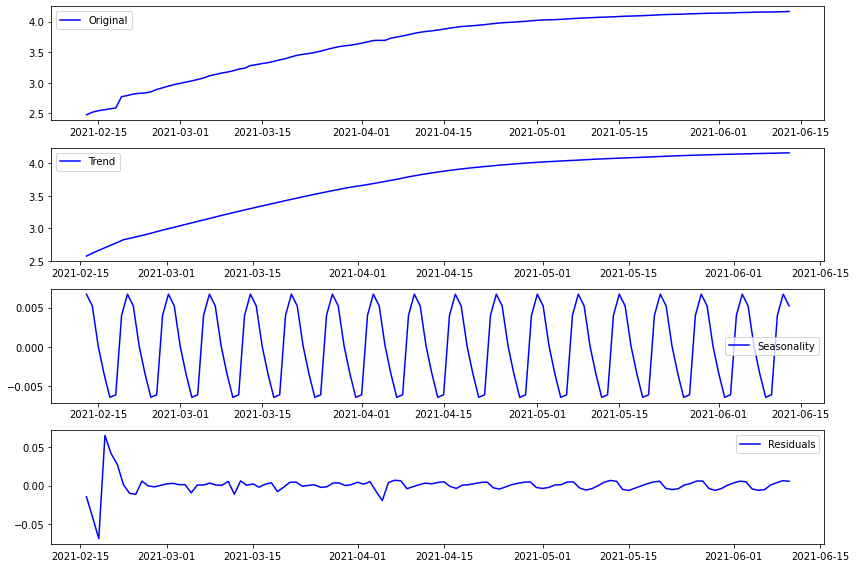

In [33]:
# visualize trend, seasonality, and residuals
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(ts1_national), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

There is definitely seasonality in the data which appears to be weekly. This can be interpreted as - day of the week matters! 


## Explore Autocorrelation & Partial Autocorrelation

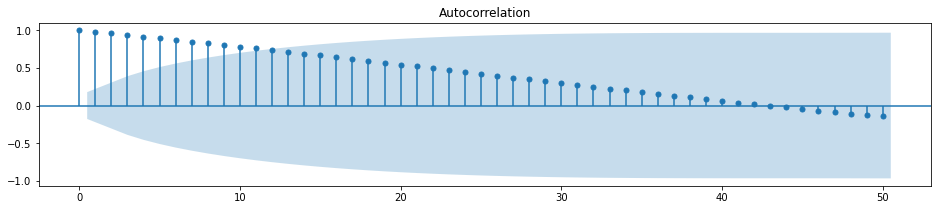

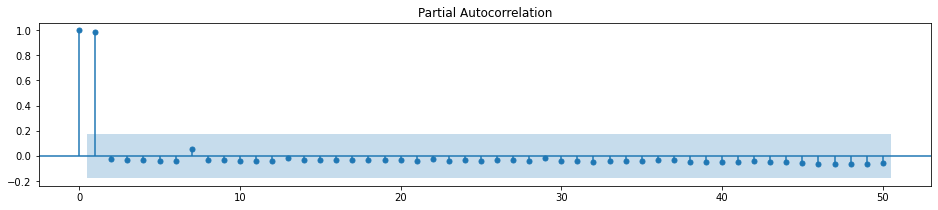

In [34]:
# regular data
func.acf_pacf_plot(ts1_national)

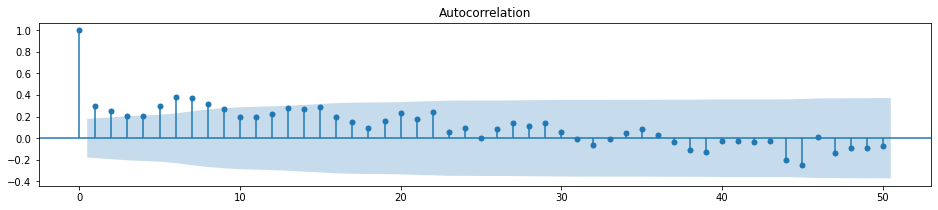

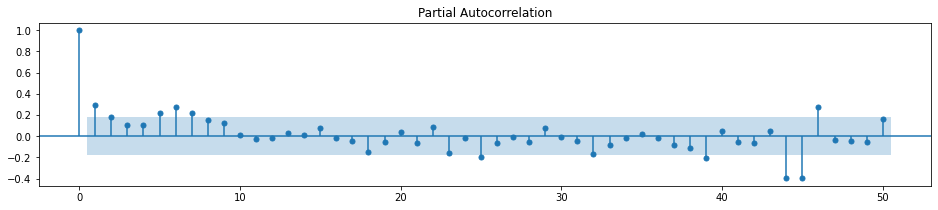

In [35]:
# differenced data
func.acf_pacf_plot(ts1_national.diff().dropna())

The partial autocorrelation plot shows a sharp drop off after one lag, suggesting an autoregressive (AR) k=1 model.

## Train Test Split

In [36]:
# calculate how far into the future I need to forecast, to determine test size
pd.to_datetime('2021-07-04') - pd.to_datetime('2021-06-13')

Timedelta('21 days 00:00:00')

<AxesSubplot:xlabel='Date'>

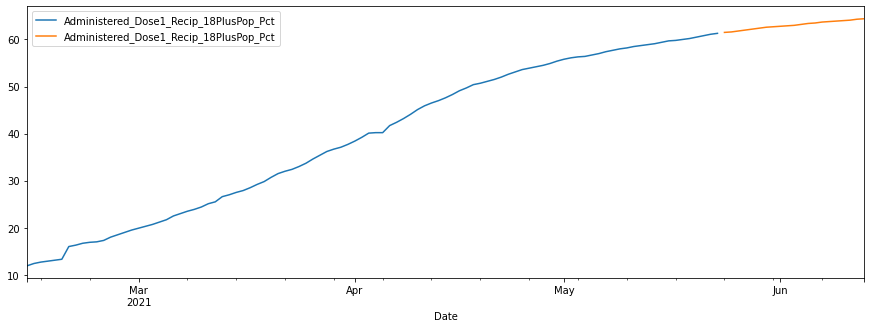

In [37]:
#ensure no overlap between train and test sets
ts1_national_train = ts1_national.iloc[:-21]
ts1_national_test = ts1_national.iloc[-21:]

fig, ax = plt.subplots()
ts1_national_train.plot(ax=ax, label='train')
ts1_national_test.plot(ax=ax, label='test')

## Seasonal Model

Because there was some seasonal variation based on day of the week, the first model will try a season term of 7. To select the autoregressive, difference, and moving average terms, I will conduct a grid search that maximizes AIC.

### Tune Parameters

In [38]:
#ignore convergence warnings that appear during grid search
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [39]:
func.grid_search_pdqs(ts1_national_train, max_range=2, s=7);

order seasonal order          AIC
57  (1, 1, 1)   (0, 0, 1, 7)   -19.751433
60  (1, 1, 1)   (1, 0, 0, 7)   -18.391198
61  (1, 1, 1)   (1, 0, 1, 7)   -18.032572
63  (1, 1, 1)   (1, 1, 1, 7)   -13.418586
47  (1, 0, 1)   (1, 1, 1, 7)    -0.281454
..        ...            ...          ...
2   (0, 0, 0)   (0, 1, 0, 7)   505.749303
9   (0, 0, 1)   (0, 0, 1, 7)   734.971341
1   (0, 0, 0)   (0, 0, 1, 7)   858.762417
8   (0, 0, 1)   (0, 0, 0, 7)   887.555781
0   (0, 0, 0)   (0, 0, 0, 7)  1025.125724

[64 rows x 3 columns]

### Model Summary

In [40]:
# fit a model using optimal parameters calculated by grid search
national_model_seasonal = tsa.SARIMAX(ts1_national_train,  
                             order=(1,1,1), 
                             seasonal_order=(0,0,1,7), 
                             enforce_invertibility=False, 
                             enforce_stationarity=False).fit()
national_model_seasonal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:     Administered_Dose1_Recip_18PlusPop_Pct   No. Observations:                  100
Model:                      SARIMAX(1, 1, 1)x(0, 0, 1, 7)   Log Likelihood                  13.876
Date:                                    Sat, 19 Jun 2021   AIC                            -19.751
Time:                                            16:43:21   BIC                             -9.752
Sample:                                        02-13-2021   HQIC                           -15.719
                                             - 05-23-2021                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9952      0.009    116.410      0.000       0.978       1.012
ma.L1         -0.8357      0.074    -11.326      0.000      -0.980      -0.691
ma.S.L7        0.2213      0.088      2.516      0.012       0.049       0.394
sigma2         0.0426      0.005      9.160      0.000       0.033       0.052
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               217.17
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                             1.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

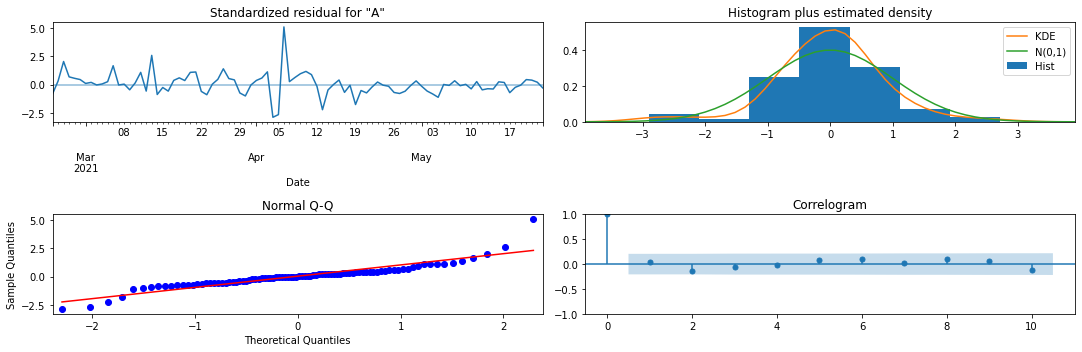

In [41]:
# review diagnostics
national_model_seasonal.plot_diagnostics()
plt.tight_layout();

Diagnostics show this to be a good model. The residuals are randomly + normally distributed, and the correlogram mirrors that of a white noise model.

### Validate

In [42]:
# plot the predictions against the actual observations
func.validate_model(national_model_seasonal, ts1_national)

lower      upper  predictions
2021-05-24  61.105303  61.914438    61.509871
2021-05-25  61.115609  62.354482    61.735046
2021-05-26  61.148954  62.783663    61.966309
2021-05-27  61.206320  63.230814    62.218567
2021-05-28  61.261985  63.679570    62.470777
2021-05-29  61.307274  64.125294    62.716284
2021-05-30  61.325093  64.552821    62.938957
2021-05-31  61.304564  65.038997    63.171781
2021-06-01  61.277865  65.529086    63.403475
2021-06-02  61.244348  66.023745    63.634047
2021-06-03  61.203692  66.523307    63.863499
2021-06-04  61.155759  67.027920    64.091839
2021-06-05  61.100519  67.537625    64.319072
2021-06-06  61.038012  68.052394    64.545203
2021-06-07  60.968315  68.572158    64.770237
2021-06-08  60.891533  69.096826    64.994179
2021-06-09  60.807785  69.626286    65.217035
2021-06-10  60.717199  70.160423    65.438811
2021-06-11  60.619908  70.699114    65.659511
2021-06-12  60.516047  71.242234    65.879141
2021-06-13  60.405750  71.789661    66.097705

This is a good model; the predictions are slightly higher than the actual observations, but well inside the upper confidence interval.

I will try a non-seasonal model next just to see if it performs any better.

## ARIMA Model

### Tune Parameters

In [43]:
#grid search optimal order parameter for an ARIMA model
func.grid_search_pdq(ts1_national_train, max_range=3)

order         AIC
17  (1, 2, 2)   56.693502
19  (2, 0, 1)   57.699503
23  (2, 1, 2)   57.897565
26  (2, 2, 2)   59.155321
7   (0, 2, 1)   60.056808
13  (1, 1, 1)   61.411930
16  (1, 2, 1)   62.744920
8   (0, 2, 2)   62.848859
20  (2, 0, 2)   62.988448
9   (1, 0, 0)   63.298308
22  (2, 1, 1)   63.411944
14  (1, 1, 2)   63.954007
25  (2, 2, 1)   64.104590
10  (1, 0, 1)   64.495397
11  (1, 0, 2)   66.007701
24  (2, 2, 0)   87.524335
21  (2, 1, 0)   90.483096
15  (1, 2, 0)   93.990295
12  (1, 1, 0)  104.553456
18  (2, 0, 0)  107.979273
6   (0, 2, 0)  116.077828
5   (0, 1, 2)  126.381764
4   (0, 1, 1)  142.873726
3   (0, 1, 0)  180.461218
2   (0, 0, 2)  572.963322
1   (0, 0, 1)  693.530221
0   (0, 0, 0)  830.724187

order         AIC
17  (1, 2, 2)   56.693502
19  (2, 0, 1)   57.699503
23  (2, 1, 2)   57.897565
26  (2, 2, 2)   59.155321
7   (0, 2, 1)   60.056808
13  (1, 1, 1)   61.411930
16  (1, 2, 1)   62.744920
8   (0, 2, 2)   62.848859
20  (2, 0, 2)   62.988448
9   (1, 0, 0)   63.298308
22  (2, 1, 1)   63.411944
14  (1, 1, 2)   63.954007
25  (2, 2, 1)   64.104590
10  (1, 0, 1)   64.495397
11  (1, 0, 2)   66.007701
24  (2, 2, 0)   87.524335
21  (2, 1, 0)   90.483096
15  (1, 2, 0)   93.990295
12  (1, 1, 0)  104.553456
18  (2, 0, 0)  107.979273
6   (0, 2, 0)  116.077828
5   (0, 1, 2)  126.381764
4   (0, 1, 1)  142.873726
3   (0, 1, 0)  180.461218
2   (0, 0, 2)  572.963322
1   (0, 0, 1)  693.530221
0   (0, 0, 0)  830.724187

### Model Summary

In [44]:
#fit the model using optimal order parameter found
national_model = tsa.arima.ARIMA(ts1_national_train,  
                                 order=(1,2,2), 
                                 enforce_invertibility=False, 
                                 enforce_stationarity=False).fit()
national_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:     Administered_Dose1_Recip_18PlusPop_Pct   No. Observations:                  100
Model:                                     ARIMA(1, 2, 2)   Log Likelihood                 -24.347
Date:                                    Sat, 19 Jun 2021   AIC                             56.694
Time:                                            16:43:23   BIC                             66.909
Sample:                                        02-13-2021   HQIC                            60.821
                                             - 05-23-2021                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9123      0.046    -19.797      0.000      -1.003      -0.822
ma.L1          0.1073    142.064      0.001      0.999    -278.333     278.547
ma.L2         -0.8927    126.809     -0.007      0.994    -249.433     247.648
sigma2         0.0940     13.352      0.007      0.994     -26.075      26.263
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2266.69
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.09   Skew:                             3.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

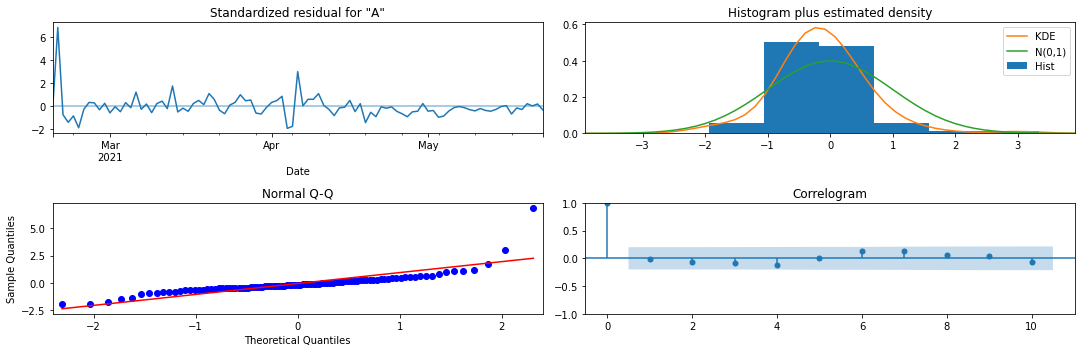

In [45]:
#review diagnostics
national_model.plot_diagnostics()
plt.tight_layout();

No red flags appear here; this seems to be a good model too.

### Validate

In [46]:
func.validate_model(national_model, ts1_national)

lower      upper  predictions
2021-05-24  60.927411  62.135217    61.531314
2021-05-25  60.887529  62.760250    61.823890
2021-05-26  60.865444  63.255705    62.060574
2021-05-27  60.883445  63.813055    62.348250
2021-05-28  60.880179  64.298631    62.589405
2021-05-29  60.903312  64.842693    62.873002
2021-05-30  60.900500  65.335256    63.117878
2021-05-31  60.917795  65.878367    63.398081
2021-06-01  60.909815  66.382292    63.646054
2021-06-02  60.917606  66.929256    63.923431
2021-06-03  60.902147  67.445817    64.173982
2021-06-04  60.899069  67.998945    64.449007
2021-06-05  60.875057  68.528349    64.701703
2021-06-06  60.860663  69.088879    64.974771
2021-06-07  60.827582  69.630925    65.229254
2021-06-08  60.801831  70.199553    65.500692
2021-06-09  60.759448  70.753874    65.756661
2021-06-10  60.722489  71.330996    66.026743
2021-06-11  60.670726  71.897173    66.283949
2021-06-12  60.622800  72.483005    66.552902
2021-06-13  60.561666  73.060611    66.811138

The non-seasonal model also performs well, and the naked eye can't decipher which is better. The primary way to mathematically confirm which model is better is by finding the lower AIC value.

In [47]:
#compare AIC values
print(f'Non-Seasonal Model AIC: {national_model.aic}')
print(f'Seasonal Model AIC: {national_model_seasonal.aic}')

Non-Seasonal Model AIC: 56.693501577226854
Seasonal Model AIC: -19.751433054509384


The seasonal model performed better than the non-seasonal model.

## National Forecast

Now I'll use the best performing national model to forecast into the future.

In [48]:
#review order parameters for the seasonal model
national_model_seasonal.model_orders

{'trend': 0,
 'exog': 0,
 'ar': 1,
 'ma': 1,
 'seasonal_ar': 0,
 'seasonal_ma': 7,
 'reduced_ar': 1,
 'reduced_ma': 8,
 'exog_variance': 0,
 'measurement_variance': 0,
 'variance': 1}

In [49]:
#fit a model on the full dataset using optimal order parameters for SARIMAX model
national_model_full = tsa.arima.ARIMA(ts1_national,  
                                      order=(1,1,1), 
                                      seasonal_order=(0,0,1,7), 
                                      enforce_invertibility=False, 
                                      enforce_stationarity=False).fit()

func.plot_forecast(national_model_full, ts1_national, steps=21, title='National Forecast to July 4th',
                  file_name='national_forecast_20210704')

Forecast for 7/4/21: 66.95849456591688


The model forecasts that 66.96% of the adult population will have received at least one vaccine dose by July 4th, coming short of the 70% goal. However, the goal is within the upper confidence interval. 

Upper confidence interval: 72.93%

Forecast: 66.96%

Lower confidence interval: 61.78%

_____

Because the data source mentions a 48 hour lag in reporting data, I want to see what the forecast through July 6th - two days past the deadline - would be.

In [50]:
#increase step size by 2 extra days
func.plot_forecast(national_model_full, ts1_national, steps=23, title='National Forecast to July 6th',
                  file_name='national_forecast_20210706')

Forecast for 7/4/21: 66.95849456591688


This lag is not projected to be very meaningful, gaining 0.22 percentage points in two days but still forecasting 67.19%, which is lower than the 70% goal. 

# Regional Analysis


As observed early, trends vary significantly by region of the US. It may be helpful to target campaigns in the final weeks leading up to July 4th in the regions that have lower administration rates. 

Let's see which region(s) need additional support.

In [51]:
ts1_region

Region  Administered_Dose1_Recip_18PlusPop_Pct
Date                                                         
2021-02-13    Midwest                               13.550000
2021-02-13  Northeast                               12.944444
2021-02-13      South                               12.747059
2021-02-13       West                               13.400000
2021-02-14    Midwest                               14.075000
...               ...                                     ...
2021-06-12       West                               63.700000
2021-06-13    Midwest                               61.058333
2021-06-13  Northeast                               75.822222
2021-06-13      South                               56.944444
2021-06-13       West                               63.800000

[484 rows x 2 columns]

In [52]:
func.plot_vax(ts1_region, color='Region',
              title="Trend in Vaccine Administration by Region (% of region pop rec'd 1 or more doses)",
              labels={'value': '% of Region Pop'})

The northeast is leading the nation, meeting the 70% goal in mid-May and reporting nearly 80% of the adult population having received at least one vaccine dose as of June 13.

The west (63.8%), midwest (61.1%), and south (57.0%) trail quite significantly, though it appears the west is on the strongest upward trajectory of the three regions. 

In the following cells, the 3 lagging regions will each be modeled to forecast what percentage they will reach by July 4th.


## West 

### Preprocessing

In [53]:
# create df, drop unused feature, and resample
ts1_west = ts1_region[ts1_region.Region == 'West']
ts1_west = ts1_west.drop(columns='Region')
ts1_west = ts1_west.resample('D').asfreq()
display(ts1_west)
ts1_west.index

Administered_Dose1_Recip_18PlusPop_Pct
Date                                              
2021-02-13                               13.400000
2021-02-14                               13.938462
2021-02-15                               14.292308
2021-02-16                               14.523077
2021-02-17                               14.684615
...                                            ...
2021-06-09                               63.338462
2021-06-10                               63.407692
2021-06-11                               63.523077
2021-06-12                               63.700000
2021-06-13                               63.800000

[121 rows x 1 columns]

DatetimeIndex(['2021-02-13', '2021-02-14', '2021-02-15', '2021-02-16',
               '2021-02-17', '2021-02-18', '2021-02-19', '2021-02-20',
               '2021-02-21', '2021-02-22',
               ...
               '2021-06-04', '2021-06-05', '2021-06-06', '2021-06-07',
               '2021-06-08', '2021-06-09', '2021-06-10', '2021-06-11',
               '2021-06-12', '2021-06-13'],
              dtype='datetime64[ns]', name='Date', length=121, freq='D')

<AxesSubplot:xlabel='Date'>

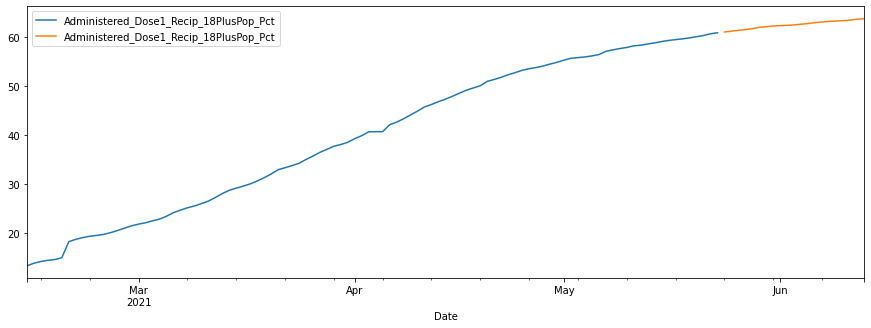

In [54]:
#train test split
ts1_west_train = ts1_west.iloc[:-21]
ts1_west_test = ts1_west.iloc[-21:]

#ensure no overlap between train and test sets
fig, ax = plt.subplots()
ts1_west_train.plot(ax=ax, label='train')
ts1_west_test.plot(ax=ax, label='test')

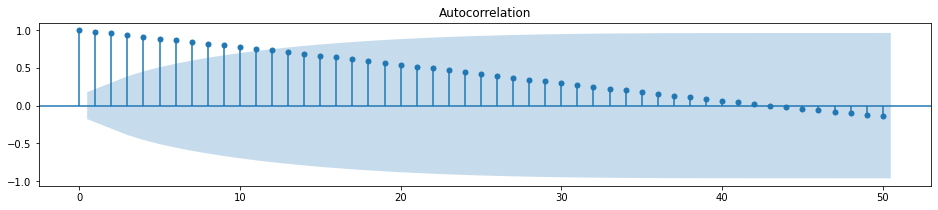

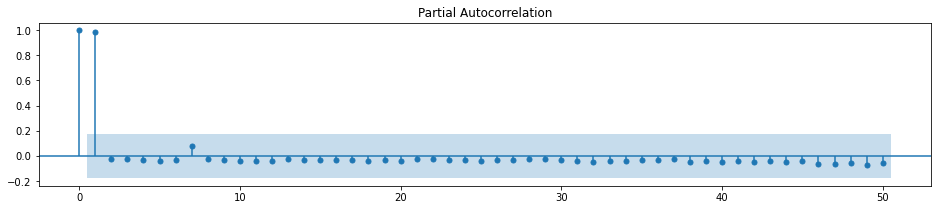

In [55]:
func.acf_pacf_plot(ts1_west)

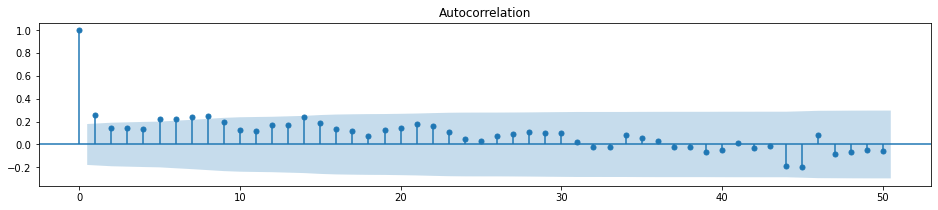

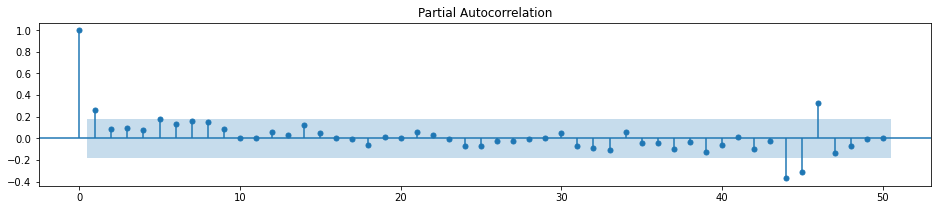

In [56]:
func.acf_pacf_plot(ts1_west.diff().dropna())

The west region closely mirrors the national trends, exhibiting some seasonality related to day of the week.

### Seasonal Model

In [57]:
# grid search optimal order parameters
func.grid_search_pdqs(ts1_west_train, max_range=3, s=7);

order seasonal order          AIC
370  (1, 1, 1)   (2, 0, 1, 7)   -33.873496
362  (1, 1, 1)   (1, 0, 2, 7)   -32.790325
198  (0, 2, 1)   (1, 0, 0, 7)   -32.660155
397  (1, 1, 2)   (2, 0, 1, 7)   -32.233883
371  (1, 1, 1)   (2, 0, 2, 7)   -31.297895
..         ...            ...          ...
2    (0, 0, 0)   (0, 0, 2, 7)   805.025460
1    (0, 0, 0)   (0, 0, 1, 7)   859.944296
27   (0, 0, 1)   (0, 0, 0, 7)   888.967905
28   (0, 0, 1)   (0, 0, 1, 7)   962.227438
0    (0, 0, 0)   (0, 0, 0, 7)  1026.584528

[729 rows x 3 columns]

In [58]:
# fit the training set using optimal orders found
west_model_s = tsa.SARIMAX(ts1_west_train,  
                             order=(1,1,1), 
                             seasonal_order=(2,0,1,7), 
                             enforce_invertibility=False, 
                             enforce_stationarity=False).fit()
west_model_s.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:     Administered_Dose1_Recip_18PlusPop_Pct   No. Observations:                  100
Model:                      SARIMAX(1, 1, 1)x(2, 0, 1, 7)   Log Likelihood                  22.937
Date:                                    Sat, 19 Jun 2021   AIC                            -33.873
Time:                                            16:46:52   BIC                            -19.289
Sample:                                        02-13-2021   HQIC                           -28.010
                                             - 05-23-2021                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9664      0.024     40.163      0.000       0.919       1.014
ma.L1         -0.8867      0.068    -13.081      0.000      -1.020      -0.754
ar.S.L7        0.7794      0.182      4.274      0.000       0.422       1.137
ar.S.L14       0.0467      0.106      0.439      0.661      -0.162       0.255
ma.S.L7       -0.7718      0.153     -5.059      0.000      -1.071      -0.473
sigma2         0.0306      0.004      8.413      0.000       0.023       0.038
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):               653.45
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                             1.86
Prob(H) (two-sided):                  0.48   Kurtosis:                        16.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

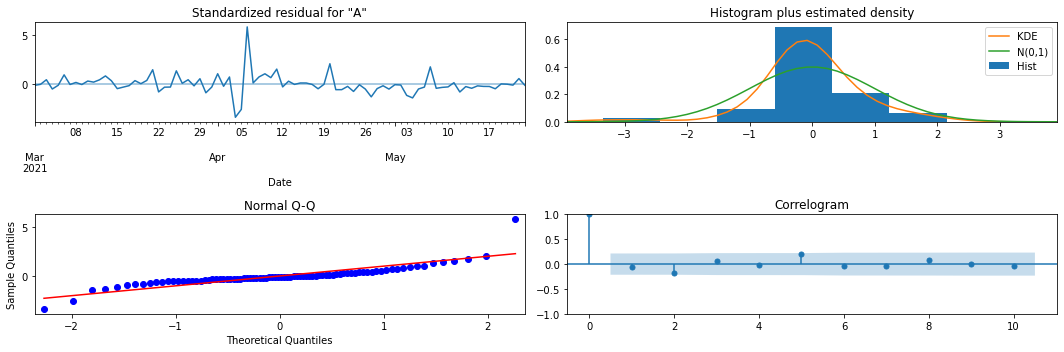

In [59]:
#review diagnostics
west_model_s.plot_diagnostics();
plt.tight_layout()

No red flags, but since the ACF/PACF showed less seasonality in the west, let's test an ARIMA model to see if it performs better.

### ARIMA Model

In [60]:
# grid search optimal order parameter
func.grid_search_pdq(ts1_west_train, max_range=3);

order         AIC
17  (1, 2, 2)   75.337958
23  (2, 1, 2)   76.091562
26  (2, 2, 2)   76.429041
9   (1, 0, 0)   78.228628
10  (1, 0, 1)   79.612769
7   (0, 2, 1)   80.622944
19  (2, 0, 1)   80.657725
13  (1, 1, 1)   81.514339
11  (1, 0, 2)   82.840977
8   (0, 2, 2)   82.853584
16  (1, 2, 1)   83.147934
14  (1, 1, 2)   83.505992
22  (2, 1, 1)   84.057724
20  (2, 0, 2)   84.101598
25  (2, 2, 1)   84.326346
24  (2, 2, 0)  107.652825
21  (2, 1, 0)  110.468271
15  (1, 2, 0)  116.132593
12  (1, 1, 0)  119.103958
18  (2, 0, 0)  122.390337
6   (0, 2, 0)  133.476862
5   (0, 1, 2)  135.867735
4   (0, 1, 1)  146.467078
3   (0, 1, 0)  180.334691
2   (0, 0, 2)  559.154860
1   (0, 0, 1)  680.974491
0   (0, 0, 0)  818.145346

In [61]:
# fit model on training set, optimal order param found
west_model = tsa.arima.ARIMA(ts1_west_train, 
                            order=(1,2,2),
                            enforce_invertibility=False,
                            enforce_stationarity=False).fit()
west_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:     Administered_Dose1_Recip_18PlusPop_Pct   No. Observations:                  100
Model:                                     ARIMA(1, 2, 2)   Log Likelihood                 -33.669
Date:                                    Sat, 19 Jun 2021   AIC                             75.338
Time:                                            16:46:54   BIC                             85.553
Sample:                                        02-13-2021   HQIC                            79.466
                                             - 05-23-2021                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8755      0.052    -16.912      0.000      -0.977      -0.774
ma.L1         -0.0876    309.137     -0.000      1.000    -605.985     605.810
ma.L2         -1.0877    336.201     -0.003      0.997    -660.029     657.854
sigma2         0.0965     29.823      0.003      0.997     -58.355      58.548
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              5001.51
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.10   Skew:                             4.82
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

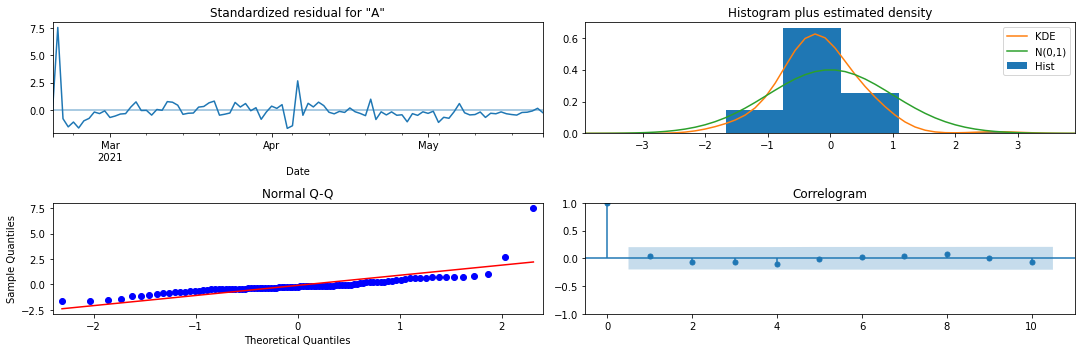

In [62]:
#review diagnostics
west_model.plot_diagnostics();
plt.tight_layout()

In [63]:
#compare AICs
print(f'Seasonal Model AIC: {west_model_s.aic}')
print(f'Non-Seasonal Model AIC: {west_model.aic}')

Seasonal Model AIC: -33.873496195487625
Non-Seasonal Model AIC: 75.33795820729108


The seasonal model performed much better, so that's the one we will forecast into the future with.

### Forecast 

In [64]:
west_model_s.model_orders

{'trend': 0,
 'exog': 0,
 'ar': 1,
 'ma': 1,
 'seasonal_ar': 14,
 'seasonal_ma': 7,
 'reduced_ar': 15,
 'reduced_ma': 8,
 'exog_variance': 0,
 'measurement_variance': 0,
 'variance': 1}

In [65]:
#fit the model on the full dataset, optimal order parameters for SARIMAX model found
west_model_full = tsa.SARIMAX(ts1_west,  
                             order=(1,1,1), 
                             seasonal_order=(2,0,1,7), 
                             enforce_invertibility=False, 
                             enforce_stationarity=False).fit()
west_model_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:     Administered_Dose1_Recip_18PlusPop_Pct   No. Observations:                  121
Model:                      SARIMAX(1, 1, 1)x(2, 0, 1, 7)   Log Likelihood                  40.562
Date:                                    Sat, 19 Jun 2021   AIC                            -69.124
Time:                                            16:46:55   BIC                            -53.200
Sample:                                        02-13-2021   HQIC                           -62.672
                                             - 06-13-2021                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9619      0.021     45.256      0.000       0.920       1.004
ma.L1         -0.8744      0.057    -15.329      0.000      -0.986      -0.763
ar.S.L7        0.7995      0.143      5.584      0.000       0.519       1.080
ar.S.L14       0.0405      0.089      0.457      0.647      -0.133       0.214
ma.S.L7       -0.8245      0.128     -6.423      0.000      -1.076      -0.573
sigma2         0.0245      0.002     10.345      0.000       0.020       0.029
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):              1401.35
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                             2.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

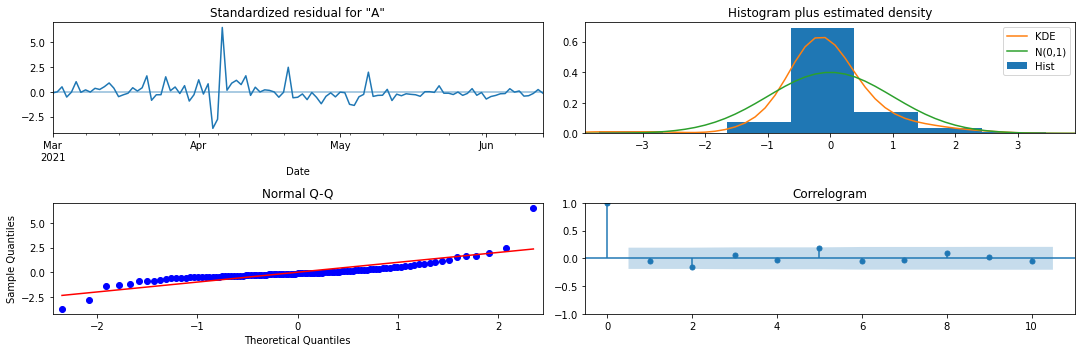

In [66]:
west_model_full.plot_diagnostics()
plt.tight_layout()

In [67]:
# forecast 21 days into the future using newly trained model
func.plot_forecast(west_model_full, ts1_west, steps=21, title='West Forecast to July 4th',
                  file_name='west_forecast')

Forecast for 7/4/21: 65.85890405105232


The west region is projected to reach 65.86% of the adult population receiving at least one vaccine dose as of July 4th.

## Midwest

### Preprocessing

In [68]:
# create df, drop unused feature, and resample
ts1_midwest = ts1_region[ts1_region.Region == 'Midwest']
ts1_midwest = ts1_midwest.drop(columns='Region')
ts1_midwest = ts1_midwest.resample('D').asfreq()
display(ts1_midwest)
ts1_midwest.index

Administered_Dose1_Recip_18PlusPop_Pct
Date                                              
2021-02-13                               13.550000
2021-02-14                               14.075000
2021-02-15                               14.400000
2021-02-16                               14.550000
2021-02-17                               14.775000
...                                            ...
2021-06-09                               60.691667
2021-06-10                               60.800000
2021-06-11                               60.816667
2021-06-12                               60.950000
2021-06-13                               61.058333

[121 rows x 1 columns]

DatetimeIndex(['2021-02-13', '2021-02-14', '2021-02-15', '2021-02-16',
               '2021-02-17', '2021-02-18', '2021-02-19', '2021-02-20',
               '2021-02-21', '2021-02-22',
               ...
               '2021-06-04', '2021-06-05', '2021-06-06', '2021-06-07',
               '2021-06-08', '2021-06-09', '2021-06-10', '2021-06-11',
               '2021-06-12', '2021-06-13'],
              dtype='datetime64[ns]', name='Date', length=121, freq='D')

<AxesSubplot:xlabel='Date'>

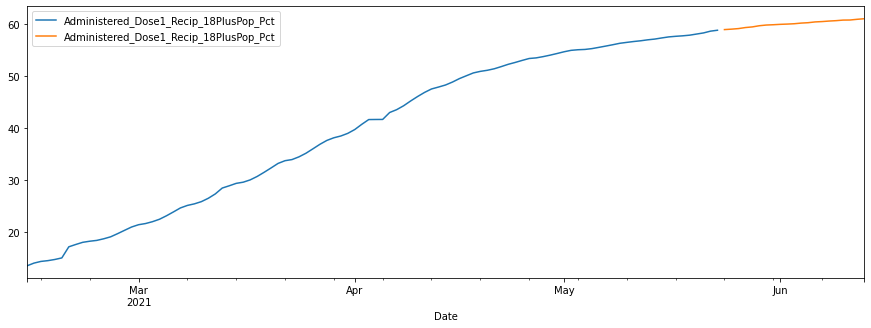

In [69]:
#train test split
ts1_midwest_train = ts1_midwest.iloc[:-21]
ts1_midwest_test = ts1_midwest.iloc[-21:]

#ensure no overlap between train and test sets
fig, ax = plt.subplots()
ts1_midwest_train.plot(ax=ax, label='train')
ts1_midwest_test.plot(ax=ax, label='test')

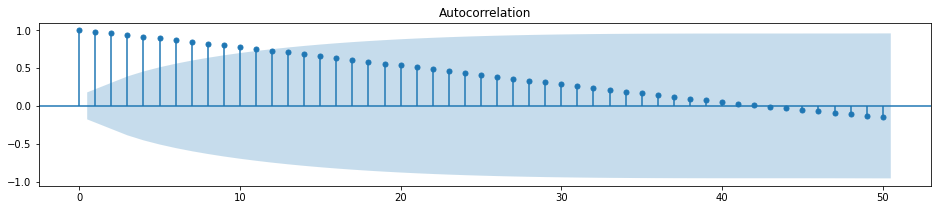

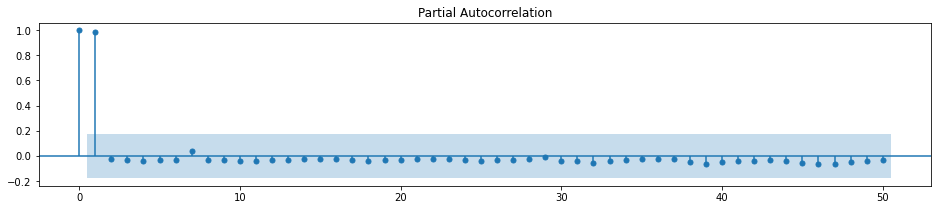

In [70]:
func.acf_pacf_plot(ts1_midwest)

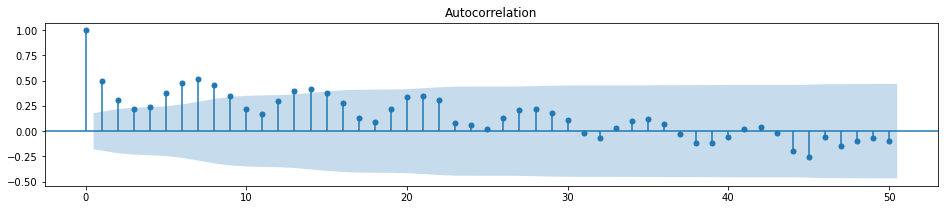

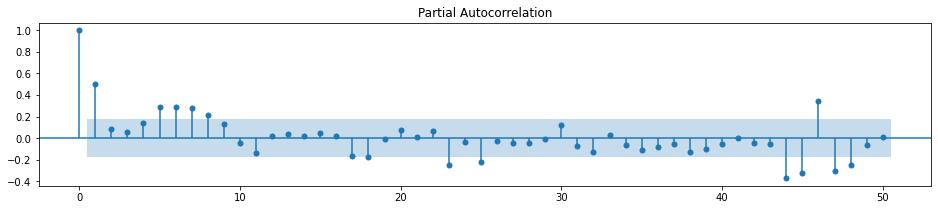

In [71]:
func.acf_pacf_plot(ts1_midwest.diff().dropna())

The midwest shows more of a seasonal trend than national and west regions, so I'll assume the seasonal model will perform better than the ARIMA model.

### Seasonal Model

In [72]:
# grid search optimal order parameters
func.grid_search_pdqs(ts1_midwest_train, max_range=3, s=7)

order seasonal order          AIC
370  (1, 1, 1)   (2, 0, 1, 7)   -32.148563
362  (1, 1, 1)   (1, 0, 2, 7)   -31.577813
397  (1, 1, 2)   (2, 0, 1, 7)   -30.705145
371  (1, 1, 1)   (2, 0, 2, 7)   -30.391593
605  (2, 1, 1)   (1, 0, 2, 7)   -29.710353
..         ...            ...          ...
55   (0, 0, 2)   (0, 0, 1, 7)   734.781081
54   (0, 0, 2)   (0, 0, 0, 7)   756.418021
27   (0, 0, 1)   (0, 0, 0, 7)   887.330746
1    (0, 0, 0)   (0, 0, 1, 7)   961.584219
0    (0, 0, 0)   (0, 0, 0, 7)  1025.004307

[729 rows x 3 columns]

order seasonal order          AIC
370  (1, 1, 1)   (2, 0, 1, 7)   -32.148563
362  (1, 1, 1)   (1, 0, 2, 7)   -31.577813
397  (1, 1, 2)   (2, 0, 1, 7)   -30.705145
371  (1, 1, 1)   (2, 0, 2, 7)   -30.391593
605  (2, 1, 1)   (1, 0, 2, 7)   -29.710353
..         ...            ...          ...
55   (0, 0, 2)   (0, 0, 1, 7)   734.781081
54   (0, 0, 2)   (0, 0, 0, 7)   756.418021
27   (0, 0, 1)   (0, 0, 0, 7)   887.330746
1    (0, 0, 0)   (0, 0, 1, 7)   961.584219
0    (0, 0, 0)   (0, 0, 0, 7)  1025.004307

[729 rows x 3 columns]

In [73]:
# train full dataset using optimal order params found
midwest_model_s = tsa.SARIMAX(ts1_midwest, 
                             order=(1,1,1),
                             seasonal_order=(2,0,1,7),
                             enforce_invertibility=False,
                             enforce_stationarity=False).fit()
midwest_model_s.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:     Administered_Dose1_Recip_18PlusPop_Pct   No. Observations:                  121
Model:                      SARIMAX(1, 1, 1)x(2, 0, 1, 7)   Log Likelihood                  39.839
Date:                                    Sat, 19 Jun 2021   AIC                            -67.679
Time:                                            16:50:18   BIC                            -51.755
Sample:                                        02-13-2021   HQIC                           -61.226
                                             - 06-13-2021                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9450      0.019     50.581      0.000       0.908       0.982
ma.L1         -0.8075      0.086     -9.405      0.000      -0.976      -0.639
ar.S.L7        0.8275      0.135      6.128      0.000       0.563       1.092
ar.S.L14       0.0295      0.109      0.270      0.787      -0.184       0.243
ma.S.L7       -1.0000    690.795     -0.001      0.999   -1354.934    1352.934
sigma2         0.0225     15.515      0.001      0.999     -30.387      30.432
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              1350.61
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.10   Skew:                             1.87
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

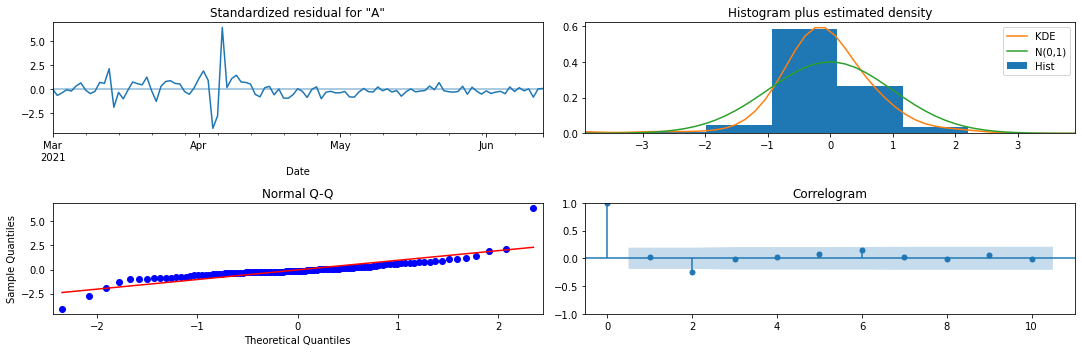

In [74]:
midwest_model_s.plot_diagnostics()
plt.tight_layout()

### Forecast 

In [75]:
func.plot_forecast(midwest_model_s, ts1_midwest, steps=21, title='Midwest Forecast to July 4th',
                  file_name='midwest_forecast')

Forecast for 7/4/21: 63.152182404186235


The midwest region is projected to reach 63.15% of the adult population receiving at least one vaccine dose as of July 4th.

## South 

### Preprocessing

In [76]:
# create df, drop unused feature, and resample
ts1_south = ts1_region[ts1_region.Region == 'South']
ts1_south = ts1_south.drop(columns='Region')
ts1_south = ts1_south.resample('D').asfreq()
display(ts1_south)
ts1_south.index

Administered_Dose1_Recip_18PlusPop_Pct
Date                                              
2021-02-13                               12.747059
2021-02-14                               13.117647
2021-02-15                               13.323529
2021-02-16                               13.452941
2021-02-17                               13.588235
...                                            ...
2021-06-09                               56.477778
2021-06-10                               56.633333
2021-06-11                               56.672222
2021-06-12                               56.838889
2021-06-13                               56.944444

[121 rows x 1 columns]

DatetimeIndex(['2021-02-13', '2021-02-14', '2021-02-15', '2021-02-16',
               '2021-02-17', '2021-02-18', '2021-02-19', '2021-02-20',
               '2021-02-21', '2021-02-22',
               ...
               '2021-06-04', '2021-06-05', '2021-06-06', '2021-06-07',
               '2021-06-08', '2021-06-09', '2021-06-10', '2021-06-11',
               '2021-06-12', '2021-06-13'],
              dtype='datetime64[ns]', name='Date', length=121, freq='D')

<AxesSubplot:xlabel='Date'>

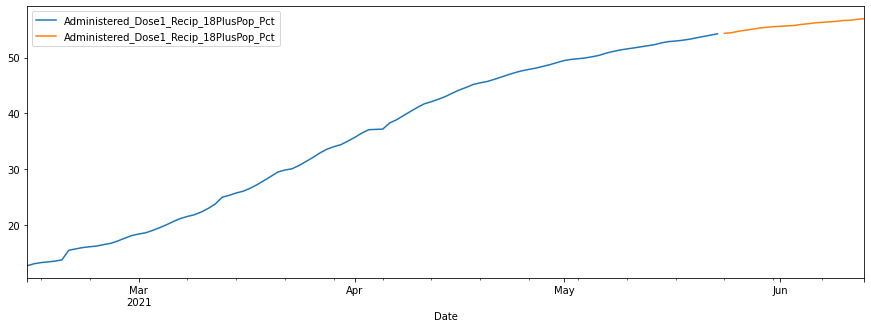

In [77]:
#train test split
ts1_south_train = ts1_south.iloc[:-21]
ts1_south_test = ts1_south.iloc[-21:]

#ensure no overlap between train and test sets
fig, ax = plt.subplots()
ts1_south_train.plot(ax=ax, label='train')
ts1_south_test.plot(ax=ax, label='test')

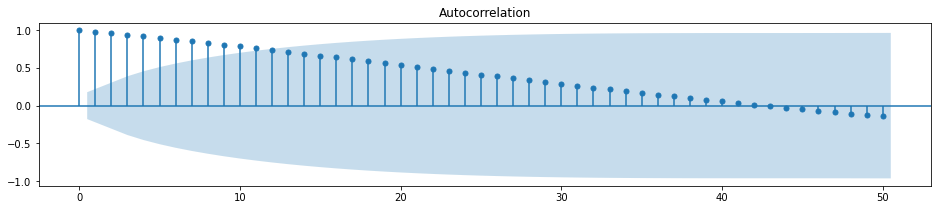

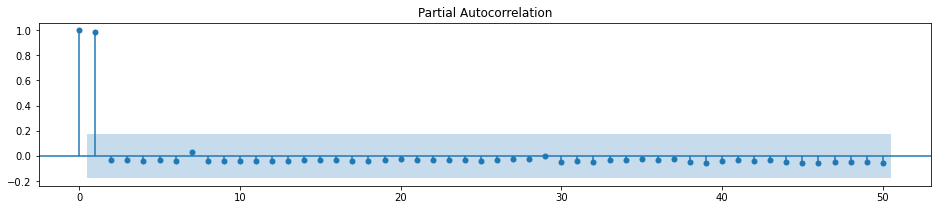

In [78]:
func.acf_pacf_plot(ts1_south)

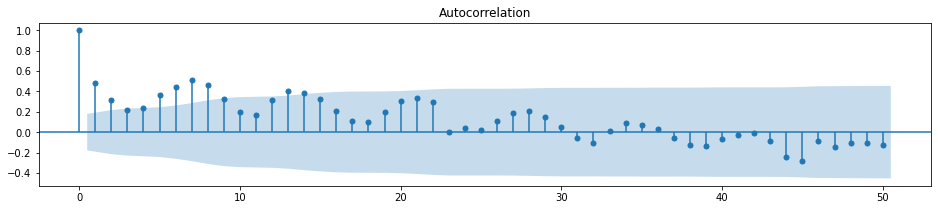

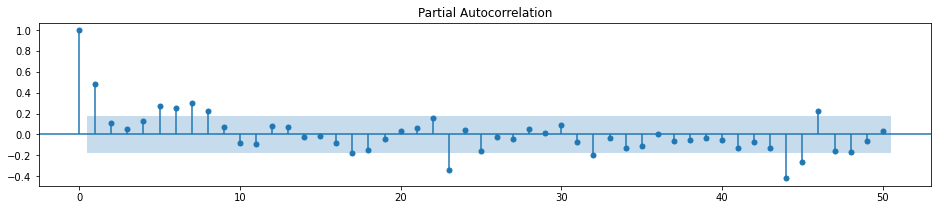

In [79]:
func.acf_pacf_plot(ts1_south.diff().dropna())

Similar to the midwest, the south also shows significant seasonality. We'll again assume that the seasonal model will perform best.

### Seasonal Model

In [80]:
func.grid_search_pdqs(ts1_south_train, max_range=3, s=7)

order seasonal order          AIC
362  (1, 1, 1)   (1, 0, 2, 7)   -61.385410
370  (1, 1, 1)   (2, 0, 1, 7)   -61.314246
397  (1, 1, 2)   (2, 0, 1, 7)   -60.725034
605  (2, 1, 1)   (1, 0, 2, 7)   -60.068558
371  (1, 1, 1)   (2, 0, 2, 7)   -59.677571
..         ...            ...          ...
2    (0, 0, 0)   (0, 0, 2, 7)   785.260831
1    (0, 0, 0)   (0, 0, 1, 7)   839.015638
27   (0, 0, 1)   (0, 0, 0, 7)   866.854325
28   (0, 0, 1)   (0, 0, 1, 7)   941.850251
0    (0, 0, 0)   (0, 0, 0, 7)  1004.271944

[729 rows x 3 columns]

order seasonal order          AIC
362  (1, 1, 1)   (1, 0, 2, 7)   -61.385410
370  (1, 1, 1)   (2, 0, 1, 7)   -61.314246
397  (1, 1, 2)   (2, 0, 1, 7)   -60.725034
605  (2, 1, 1)   (1, 0, 2, 7)   -60.068558
371  (1, 1, 1)   (2, 0, 2, 7)   -59.677571
..         ...            ...          ...
2    (0, 0, 0)   (0, 0, 2, 7)   785.260831
1    (0, 0, 0)   (0, 0, 1, 7)   839.015638
27   (0, 0, 1)   (0, 0, 0, 7)   866.854325
28   (0, 0, 1)   (0, 0, 1, 7)   941.850251
0    (0, 0, 0)   (0, 0, 0, 7)  1004.271944

[729 rows x 3 columns]

In [81]:
south_model = tsa.SARIMAX(ts1_south, 
                         order=(1,1,1),
                         seasonal_order=(1,0,2,7),
                         enforce_stationarity=False,
                         enforce_invertibility=False).fit()
south_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:     Administered_Dose1_Recip_18PlusPop_Pct   No. Observations:                  121
Model:                 SARIMAX(1, 1, 1)x(1, 0, [1, 2], 7)   Log Likelihood                  57.515
Date:                                    Sat, 19 Jun 2021   AIC                           -103.030
Time:                                            16:54:04   BIC                            -87.164
Sample:                                        02-13-2021   HQIC                           -96.602
                                             - 06-13-2021                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9423      0.021     44.170      0.000       0.900       0.984
ma.L1         -0.8585      0.055    -15.598      0.000      -0.966      -0.751
ar.S.L7        0.8687      0.050     17.241      0.000       0.770       0.967
ma.S.L7       -0.8836    797.707     -0.001      0.999   -1564.360    1562.593
ma.S.L14      -0.1164     92.781     -0.001      0.999    -181.963     181.730
sigma2         0.0161     12.879      0.001      0.999     -25.226      25.259
===================================================================================
Ljung-Box (L1) (Q):                   0.70   Jarque-Bera (JB):               632.12
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               0.08   Skew:                             1.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

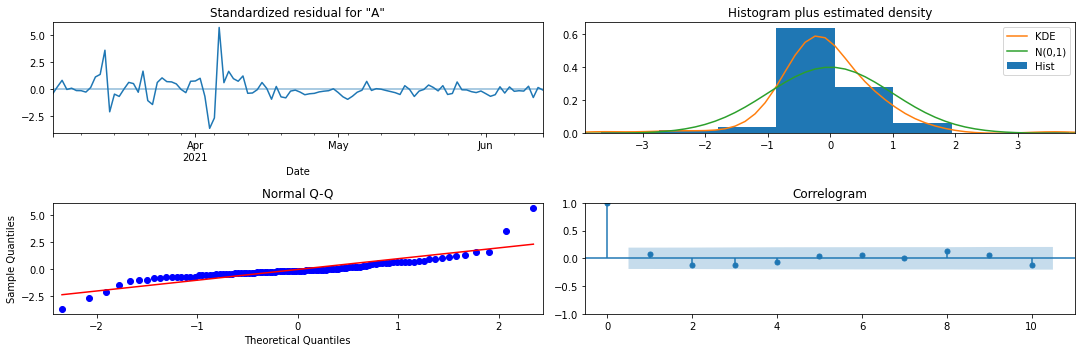

In [82]:
south_model.plot_diagnostics();
plt.tight_layout()

### Forecast

In [83]:
func.plot_forecast(south_model, ts1_south, steps=21, title='South Forecast to July 4th',
                  file_name='south_forecast')

Forecast for 7/4/21: 59.244956235004196


The south projects only reaching 59.24% of the adult population by July 4th, representing **the largest opportunity area for vaccine campaign activities.**

# Administration Rate

Based on discussion on the US national news, one would believe the country has a surplus of vaccines. I wanted to dig into this at a regional level to understand if reallocating vaccines to areas where people are more interested might help the country's overall percentages.

To do so, I engineered a feature *Administration Rate* to represent how many vaccines were administered per 1 vaccine distributed. 

- A value of 1.0 would indicate a jurisdiction is administering every single vaccine they have. This might indicate the region could administer more if they had more available. 

- A value just under 1.0 is optimal, meaning vaccines are being appropriately distributed and not wasted.

- Lower values indicate opportunity to either reallocate unused vaccines or encourage the population to use what is available to them. For example, a value of 0.5 indicates the region is only administering half of the vaccines they have.

In [84]:
# parse out relevant features
allocation_df = full_dataset[['Date', 'Location', 'Distributed', 'Administered']]

In [85]:
# engineer availability ratio feature, reset index, and 
# begin analysis at the same date as the rest of the analysis
allocation_df['Administration Rate'] = allocation_df['Administered'] / allocation_df['Distributed']
allocation_df['Date'] = pd.to_datetime(allocation_df['Date'])
allocation_df.set_index('Date', inplace=True)
allocation_df=allocation_df[:'2021-02-13']

<ipython-input-85-a48a68e75390>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-85-a48a68e75390>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [86]:
# calculate region using previously defined function, drop irrelevant columns
allocation_df['Region'] = allocation_df['Location'].map(lambda x: region(x))
allocation_df.drop(columns=['Location', 'Distributed', 'Administered'], inplace=True)
allocation_df

Administration Rate     Region
Date                                      
2021-06-13             0.892601    Midwest
2021-06-13             0.781465      South
2021-06-13             0.726312      South
2021-06-13             0.879236       West
2021-06-13             0.959523       West
...                         ...        ...
2021-02-14             0.773679  Northeast
2021-02-14             0.617341  Northeast
2021-02-14             0.880225    Midwest
2021-02-14             0.811275       West
2021-02-14             0.835553      South

[7800 rows x 2 columns]

In [87]:
#drop null values
allocation_df = allocation_df[allocation_df['Region'] != '']

Because there is seasonality in the data - day of the week matters - a weekly average will more clearly show overall trends without as much noise. The following cells parse each region into their own dataframe to be resampled, then brings them back together for graphing.

In [88]:
#parse south region and resample 
south_allocation = allocation_df[allocation_df['Region'] == 'South']
south_allocation = south_allocation.drop(columns='Region').resample('W').mean()
south_allocation['Region'] = 'South'

In [89]:
#parse west region and resample
west_allocation = allocation_df[allocation_df['Region'] == 'West']
west_allocation = west_allocation.drop(columns='Region').resample('W').mean()
west_allocation['Region'] = 'West'

In [90]:
#parse midwest and resample
midwest_allocation = allocation_df[allocation_df['Region'] == 'Midwest']
midwest_allocation = midwest_allocation.drop(columns='Region').resample('W').mean()
midwest_allocation['Region'] = 'Midwest'

In [91]:
#parse northeast and resample
northeast_allocation = allocation_df[allocation_df['Region'] == 'Northeast']
northeast_allocation = northeast_allocation.drop(columns='Region').resample('W').mean()
northeast_allocation['Region'] = 'Northeast'

In [92]:
#combine back into one df for easy graphing
allocation_df = pd.concat([midwest_allocation, 
                           northeast_allocation,
                           south_allocation, 
                           west_allocation], axis=0)

In [93]:
#check for data leakage
allocation_df['Region'].value_counts()

South        18
Midwest      18
Northeast    18
West         18
Name: Region, dtype: int64

In [94]:
#visualize availability ratios by region
fig = px.line(x=allocation_df.index, 
              y=allocation_df['Administration Rate'], 
              color=allocation_df['Region'],
             title='Doses Administered Per Distributed by Region',
             labels={'x': 'Date',
                     'y': 'Administration Rate',
                     'color': 'Legend'})
#styling
fig.update_layout(plot_bgcolor='#f2f2f2', height=500, width=1000)

#save fig
fig.write_image('./images/Administration Rate Over Time by Region.jpg')
fig.show()

The availability ratio shows the south lagging significantly in the number of doses administered per vaccine distributed. This leads us to believe that the challenge is not a lack of vaccine availability, rather there may be a lack of interest from the population in getting vaccinated. 

# Summary & Recommendations

**KEY TAKEAWAYS**


Based on an analysis of the CDC's COVID-19 Vaccine Administration tracker as of June 13, 2021, it is predicted that the US will not reach their goal of administering at least one vaccine dose to 70% of the adult population. However, the goal is not far off, and additional campaigning in the areas lagging behind may help close the gap. 

The northeast region is leading the nation in vaccine administration, having achieved the 70% administration goal in mid-May and continuing an upward trajectory since then. The south is lagging behind in both vaccine administration as a percentage of the adult population and in efficiently administering the vaccines distributed to the region. 

____



**RECOMMENDATIONS**

In the remaining weeks leading up to July 4th, the Biden administration should take the following actions to increase the chances of meeting their goal:

- Continue community-based vaccine education and local outreach efforts, focusing on this aspect of the campaign most

- Launch a nation-wide educational campaign explaining the benefits and risks of COVID-19 vaccination and debunking common misconceptions about the vaccines

- Focus investments in the south

# Future Enhancements

- Codify references to the optimal order and seasonal order found in grid search for use when training the actual model

- Calculate mean squared error within model validation step


# Appendix

Simplified plot of regional trends

In [95]:
#plot timeseries in range
fig = px.line(ts1_region, color='Region', 
              title="Vaccine Administration by Region (% of adult pop. with ≥1 dose)", 
              range_x=('2021-02-12', '2021-07-04'), 
              labels={'value': '% of Adult Pop. with ≥1 Dose'})

#plot horizontal line at goal of 70% first dose administered
fig.add_trace(go.Scatter(
    x=[0, '2021-04-20', '2021-07-04'],
    y=[70, 70, 70],
    mode="lines+text",
    line=go.scatter.Line(color='black'),
    name="% goal - 70%",
    text=[None, "National Goal: 70%", None],
    textposition="top center",
    textfont={'size':12}))

#styling
fig.update_layout(plot_bgcolor='#f2f2f2', height=500, width=1000)

#save fig
fig.write_image(f'./images/simplified_regional_trend.jpg')
fig.show()